### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I went to use google colab because there are some problems of importing some packages of tensorflow and some inconsistencies on my computer.

### Importing Libraries

In [2]:
import numpy as np  
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding
# sklearn
from sklearn.model_selection import train_test_split
# text preprocessing
import nltk
# options
# Increase width to see the article_title clearly
pd.set_option('display.max_colwidth', None)
sns.set(style='whitegrid', font_scale=1.5)

# our project path
project_path = '/content/drive/MyDrive/Colab Notebooks/Project 5'
# check working directory
print("Working directory:", os.getcwd())
# change working directory and list all files in project directory
os.chdir(project_path)
print("New working directory", project_path)
print()
for dirname, _, filenames in os.walk(project_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Working directory: /content
New working directory /content/drive/MyDrive/Colab Notebooks/Project 5

/content/drive/MyDrive/Colab Notebooks/Project 5/model building and evaluation/ml_model.html
/content/drive/MyDrive/Colab Notebooks/Project 5/model building and evaluation/ml_models.ipynb
/content/drive/MyDrive/Colab Notebooks/Project 5/model building and evaluation/LSTM_based_model.ipynb
/content/drive/MyDrive/Colab Notebooks/Project 5/model building and evaluation/.ipynb_checkpoints/ml_models-checkpoint.ipynb
/content/drive/MyDrive/Colab Notebooks/Project 5/model building and evaluation/.ipynb_checkpoints/LSTM_based_model-checkpoint.ipynb
/content/drive/MyDrive/Colab Notebooks/Project 5/data cleaning/data_cleaning.html
/content/drive/MyDrive/Colab Notebooks/Project 5/data cleaning/data_cleaning.ipynb
/content/drive/MyDrive/Colab Notebooks/Project 5/data cleaning/clean_df.csv
/content/drive/MyDrive/Colab Notebooks/Project 5/data cleaning/.ipynb_checkpoints/data_cleaning-checkpoint.ipynb

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 5/data preprocessing/final_df_2.csv').drop(columns = ['Unnamed: 0'])
data

,final_text,category
0,egyptbas paymob rais 50 mln seri b fund round egyptbas paymob financi servic merchant platform rais 50 million seri b fund platform use grow product rang expand egyptian market well new market across middl east africa region,economy
1,egyptâ inflat speed amid war ukrain rise food energi price egyptâ headlin annual inflat rate acceler 149 percent april 121 percent record march 44 percent correspond month 2021 central agenc public mobilis statist capma announc tuesday,economy
2,ebrd upgrad egyptâ gdp growth forecast fy202122 08 european bank reconstruct develop ebrd rais project egyptâ gdp growth current fy202122 57 percent â end june â 49 percent project novemb slow 5 percent fy202223 â begin juli â accord region econom prospect report bank releas tuesday,economy
3,gold price egypt amid uncertain econom outlook expect dollar price hike gold price egyptian market saw fluctuat monday amid uncertainti cast expect rise u dollar price inflat caus russian war ukrain well rise food energi price,economy
4,egypt eu ink â¬138 mln develop financ deal cover sever sector egypt european union eu deleg egypt sign monday number develop financ agreement worth â¬138 million cover healthcar administr reform environ rural social develop enhanc govern,economy
...,...,...
30594,chekhov three sister visit auc anton chekhovã¯â¿â½ã¯â¿â½ã¯â¿â½ three sister direct frank bradley perform auc student de,art
30595,egyptian critic win polish cultur award professor hanaa abdel fattah recognis poland ministri foreign affair,art
30596,examin act myth misconcept lectur theatr director professor mahmoud ellozi auc,art
30597,juliu caesar twist al hayat theatr ensembl add twist shakespearean play juliu caesar win 3rd place el sawi culturewheel 8th theatr festiv,art


### LSTM Modelling:

1.   Vectorize title articles, by turning each text into either a sequence of integers into a vector.


2.  Limit the dataset to the top 'n_most_common_words'


3.  Find the longest article in terms of number of words,
    and set the max number of words for article title.
    



In [4]:
# get articles lengthes.
lens = [len(article) for article in data['final_text']]
# max. number of words in articles
max_words, min_words = np.max(lens), np.min(lens)
print(max_words, min_words)

402 7


### To avoid error

In [5]:
#nltk.download('punkt')

In [6]:
# Count total number of unique words in our training set
text_tokens = [nltk.word_tokenize(i) for i in data['final_text']]

In [8]:
# The first article has 28 unique worsd
print(set(text_tokens[0]))
print(len(set(text_tokens[0])))

print()

print(set(text_tokens[1]))
print(len(set(text_tokens[1])))

{'fund', 'middl', 'merchant', 'egyptbas', 'b', 'rais', 'seri', 'servic', 'financi', 'well', 'expand', 'across', 'market', 'africa', 'product', 'million', 'use', '50', 'egyptian', 'rang', 'region', 'east', 'paymob', 'new', 'mln', 'grow', 'platform', 'round'}
28

{'food', 'month', 'statist', 'rise', 'war', 'ukrain', 'march', '44', 'inflat', 'tuesday', 'rate', 'correspond', 'mobilis', 'amid', 'price', 'april', 'capma', '121', 'acceler', '149', 'agenc', 'headlin', 'speed', 'egyptâ\x80\x99', 'energi', 'record', 'annual', '2021', 'public', 'percent', 'central', 'announc'}
32


In [9]:
# try to find the total number of unique words in our corpus
total_nb_words = 0

for i in range(len(data['final_text'])):
    total_nb_words += len(set(text_tokens[i]))
    
print(f"Total Number of unique words in our corpus is {total_nb_words}")

Total Number of unique words in our corpus is 421125


In [10]:
# Set the max_nb_words to appropriate value
max_sequence_length = 300
# Limit the dataset to the top 50,000 top words
max_nb_common_words = 50000
# Embedding vectors dimension ,This is fixed
embedding_dim = 100

In [11]:
# Keras tokneizer
tokenizer = Tokenizer(num_words = max_nb_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['final_text'].values)

Once fit, the tokenizer provides 4 attributes that you can use to query what has been learnt about your documents:

* word_counts: A dictionary of words and their counts

* word_docs: A dictionary of words and many documents each appeared in

* word_index: A dictionary of words and their uniquely assigned integers

* document_count: An integer count of the total number of documents that we used to fit the tokenizer

In [12]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')
print(word_index)

Found 25323 unique tokens
{'egypt': 1, 'film': 2, 'egyptian': 3, 'art': 4, 'festiv': 5, 'cairo': 6, 'leagu': 7, 'new': 8, 'say': 9, 'artist': 10, 'perform': 11, 'year': 12, 'world': 13, 'alert': 14, 'cultur': 15, 'intern': 16, 'onlin': 17, 'first': 18, 'music': 19, 'bank': 20, 'minist': 21, 'arab': 22, 'win': 23, 'citi': 24, 'ahram': 25, 'exhibit': 26, 'open': 27, 'champion': 28, 'theatr': 29, 'premier': 30, 'screen': 31, 'match': 32, 'week': 33, 'opera': 34, 'follow': 35, 'take': 36, 'season': 37, 'invest': 38, 'two': 39, 'award': 40, 'director': 41, 'project': 42, 'real': 43, 'concert': 44, 'unit': 45, 'play': 46, 'egyptâ\x80\x99': 47, 'billion': 48, 'madrid': 49, 'manchest': 50, 'liverpool': 51, 'cup': 52, 'market': 53, 'man': 54, 'said': 55, 'work': 56, 'percent': 57, 'hous': 58, 'return': 59, 'countri': 60, 'sign': 61, 'million': 62, 'end': 63, 'barcelona': 64, 'club': 65, 'seri': 66, 'event': 67, 'alexandria': 68, 'coverag': 69, 'oil': 70, 'one': 71, 'chelsea': 72, 'day': 73, 'pl

**Truncate and pad the input sequences so that they are all in the same length for modelling.**

In [14]:
X = tokenizer.texts_to_sequences(data['final_text'].values)

[[3722, 5493, 289, 660, 192, 66, 2251, 158, 476, 3722, 5493, 279, 472, 8614, 800, 289, 660, 62, 66, 2251, 158, 800, 412, 582, 213, 1632, 724, 3, 53, 507, 8, 53, 346, 393, 362, 325, 310], [47, 296, 3002, 149, 503, 589, 104, 679, 328, 102, 47, 1283, 243, 296, 81, 1387, 10358, 57, 144, 5956, 57, 171, 100, 2160, 57, 6557, 85, 285, 136, 1021, 218, 3572, 1869, 607, 78, 145], [851, 1082, 47, 424, 155, 1217, 1451, 6558, 185, 20, 2408, 98, 851, 289, 42, 47, 424, 155, 335, 1451, 1838, 57, 2069, 63, 191, 2069, 2161, 57, 42, 156, 993, 409, 57, 4509, 2069, 511, 228, 2069, 389, 310, 90, 1904, 91, 20, 163, 145], [830, 102, 1, 149, 2657, 90, 981, 119, 413, 102, 764, 830, 102, 3, 53, 1118, 5093, 194, 149, 1979, 2252, 119, 104, 103, 413, 102, 296, 858, 399, 503, 589, 507, 104, 679, 328, 102], [1, 552, 1294, 10359, 192, 98, 86, 75, 940, 438, 159, 1, 185, 910, 552, 1012, 1, 61, 194, 410, 98, 86, 349, 447, 10359, 62, 940, 2162, 1720, 347, 1773, 3102, 425, 98, 1671, 160], [3, 324, 1136, 2912, 73, 20, 159, 6

In [15]:
# Indices of words in our words dictionary
print("X after texts_to_sequences()", X[0])

[3722, 5493, 289, 660, 192, 66, 2251, 158, 476, 3722, 5493, 279, 472, 8614, 800, 289, 660, 62, 66, 2251, 158, 800, 412, 582, 213, 1632, 724, 3, 53, 507, 8, 53, 346, 393, 362, 325, 310]


In [16]:
X = pad_sequences(X, maxlen = max_sequence_length)

In [19]:
print("Shape of data tensor", X.shape)
print()
print("First article vector:\n", X[0])

Shape of data tensor (30599, 300)

First article vector:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    

**Converting categorical labels to numbers**

In [ ]:
Y = pd.get_dummies(data['category']).values
print("Shape of label tensor:", Y.shape)

Shape of label tensor: (30599, 3)


**Tain test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (24479, 300) (24479, 3)
Test shapes: (6120, 300) (6120, 3)


### Model building

In [ ]:
model = Sequential()
# The first layer is the embedding layer that uses a 100 length vector to represent each word
model.add(Embedding(max_nb_common_words, embedding_dim, input_length = max_sequence_length))
# a drop out layer
model.add(Dropout(0.2))
# LSTM with 100 memory units
model.add(LSTM(100))
# The output layer must create 3 values, one for each class
model.add(Dense(3))
# Softmax activation to calculate class probabilities
model.add(Activation('softmax'))
# Because of multi-class classification, categorical_crossentropy is used as loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 128
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/3
173/173 [==============================] - 185s 1s/step - loss: 0.2827 - accuracy: 0.8916 - val_loss: 0.0365 - val_accuracy: 0.9902
Epoch 2/3
173/173 [==============================] - 164s 948ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0308 - val_accuracy: 0.9906
Epoch 3/3
173/173 [==============================] - 164s 947ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 0.0220 - val_accuracy: 0.9922


### Visualization of training and validation loss

In [ ]:
history.history

{'accuracy': [0.8915618658065796, 0.995914876461029, 0.9991829991340637],
 'loss': [0.2826812267303467, 0.017440391704440117, 0.005202196538448334],
 'val_accuracy': [0.9901960492134094, 0.9906045794487, 0.9922385811805725],
 'val_loss': [0.03648550435900688, 0.030753159895539284, 0.021954741328954697]}

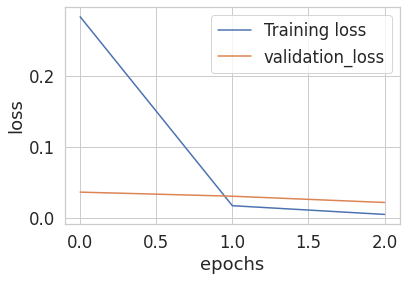

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.array(history.history['loss']), label='Training loss')
ax.plot(np.array(history.history['val_loss']), label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
ax.legend()
plt.show()

### Visualization of training and validation accuracies

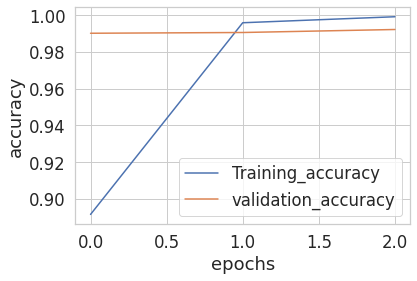

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.array(history.history['accuracy']), label='Training_accuracy')
ax.plot(np.array(history.history['val_accuracy']), label='validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
ax.legend()
plt.show()

### Model Evaluation

In [ ]:
accuracy = model.evaluate(X_test,y_test)
print(f'Test set: Loss: {accuracy[0]}, Accuracy: {accuracy[1]}')

192/192 [==============================] - 13s 67ms/step - loss: 0.0272 - accuracy: 0.9904
Test set: Loss: 0.027157604694366455, Accuracy: 0.9903594851493835


### User input test

In [ ]:
text = ["money football clubs in england can not achieve the champions league not matter how much they try"]
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen = max_sequence_length)
pred = model.predict(padded)
labels = ["Art", "Economy", "Sports"]
print("Predicted category is :", labels[np.argmax(pred)])

Predicted category is : Sports
